# COVID-19 cases by country

JHU dataset: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv

In [1]:
# Plots inline with the code
%matplotlib inline

# Data manipulation and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Libraries to read data from web downloads and generate a dataframe
import requests
from io import StringIO


In [2]:
# Sets the notebook to use the full width of the window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

## Datasets

* Grab the new data via HTTPS
* Transform the awkward table into column format with a section for each country
* Group by country
* Count number of days since first reported case

In [3]:
url_prefix = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/'
# Get data via github
# Transform awkward JHU table
def get_jhu_dataset(data_file):
    # Get the latest updates from JHU via github
    data_web = requests.get('{}{}'.format(url_prefix, data_file), allow_redirects=True)
    data_io = StringIO(data_web.text)
    df = pd.read_csv(data_io)
    df.drop(['Long', 'Lat'], axis=1, inplace=True)

    # Break the akward table into sections for each country
    df_list = list()
    for c in set(df['Country/Region']):
        country = c
        totals = df[df['Country/Region'] == country].sum()
        daily_new_cases = totals[2:].diff()
        # Place back first row
        daily_new_cases[0] = totals[2]
        df_country = pd.DataFrame(daily_new_cases)
        df_country = df_country.rename(columns={0:'daily_new_cases'})
        df_country['country'] = country
        df_list.append(df_country)
        
    # Put all sections of countries into a single dataframe
    df_all = pd.concat(df_list)
    df_all = df_all.reset_index().rename(columns={'index':'date'})
    df_all = df_all[df_all['daily_new_cases'] > 0]
    df_all['date'] = pd.to_datetime(df_all['date'])
    return df_all


In [70]:
def get_topN_by_total(df, number_countries):
    groups =  df.groupby('country')
    top_n = list(groups['daily_new_cases'].sum().sort_values(ascending=False).keys()[0:number_countries])
    return top_n

# Group by country
# Count days since first reported case
def group_by_country(df, top_n_countries):
    n = len(top_n_countries)
    topN_df = df[df['country'].isin(top_n_countries)]
    df_list = list()
    for c in top_n_countries:
        first_case = topN_df[topN_df['country'] == c]['date'].min()
        days_since_first_case = topN_df[topN_df['country'] == c]['date'] - first_case
        country_df = pd.DataFrame()
        country_df['days_since_first_case'] = days_since_first_case
        country_df['new_cases'] =  np.int64(topN_df[topN_df['country'] == c]['daily_new_cases'])
        total_cases = country_df['new_cases'].sum()
        country_df['Country'] = '{}: {:,}'.format(c, total_cases)
        df_list.append(country_df)
        print('{}: {}'.format(c, total_cases))

    countries_df = pd.concat(df_list, ignore_index=True)
    countries_df['days_since_first_case'] = countries_df['days_since_first_case'].dt.days
    return countries_df


In [72]:
def plot_grid(countries_df, col_wrap=4, x_label=None, y_label=None):
    if x_label is not None:
        new_x_label = x_label
    else:
        new_x_label = 'days_since_first_case'
    if y_label is not None:
        new_y_label = y_label
    else:
        new_y_label = 'new_cases'
        
    plot_df = countries_df.rename(columns={'days_since_first_case':new_x_label, 'new_cases':new_y_label})
        
    sns.set(style="ticks")
    with sns.axes_style("darkgrid"):
        grid = sns.FacetGrid(plot_df, col="Country", hue='Country', col_wrap=col_wrap, height=3)
        g = grid.map(plt.plot, new_x_label, new_y_label)
        g = grid.map(plt.fill_between, new_x_label, new_y_label, alpha=0.2).set_titles("{col_name}")
        

        #grid.fig.tight_layout(w_pad=1)
        #grid.set(ylim = [-20,10000])

# Confirmed cases

China: 81591
Italy: 69176
US: 53740
Spain: 39885
Germany: 32986
Iran: 24811
France: 22622
Switzerland: 9877
Korea, South: 9037
United Kingdom: 8164
Netherlands: 5580
Austria: 5283


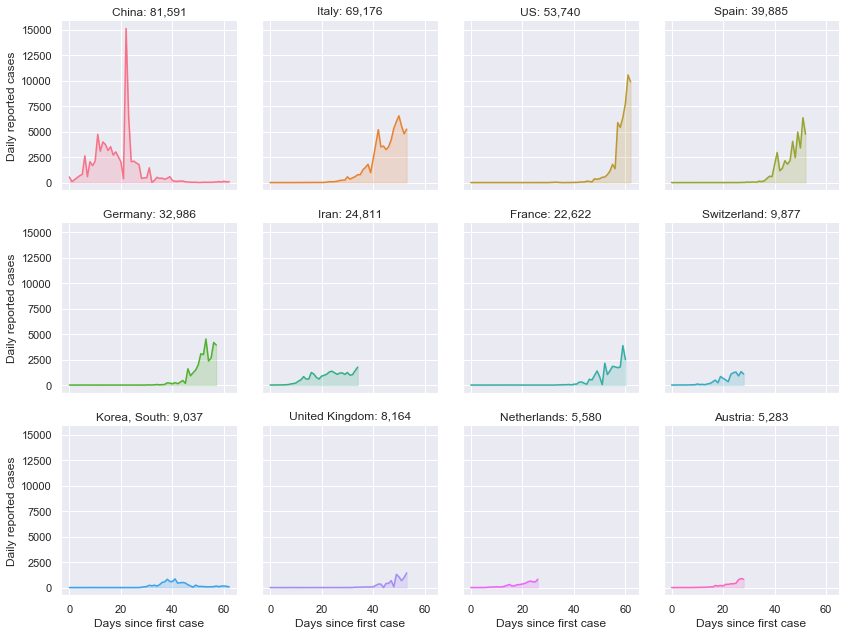

In [73]:
confirmed_df = get_jhu_dataset('time_series_covid19_confirmed_global.csv')
topN_countries_by_total = get_topN_by_total(confirmed_df, 12)
confirmed_countries_df = group_by_country(confirmed_df, topN_countries_by_total)
plot_grid(confirmed_countries_df, x_label='Days since first case', y_label='Daily reported cases')


# Deaths

China: 3281
Italy: 6820
US: 706
Spain: 2808
Germany: 157
Iran: 1934
France: 1102
Switzerland: 122
Korea, South: 120
United Kingdom: 423
Netherlands: 277
Austria: 28


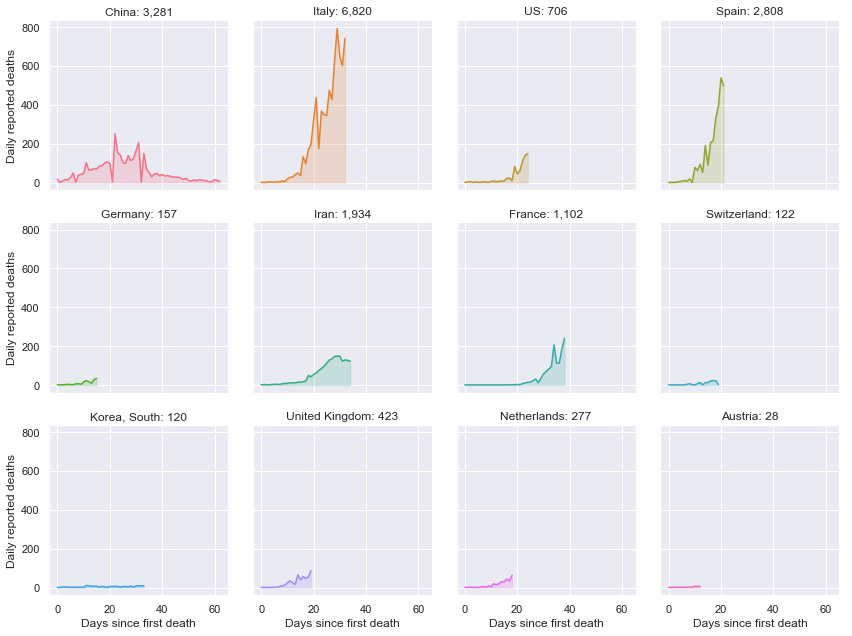

In [74]:
deaths_df = get_jhu_dataset('time_series_covid19_deaths_global.csv')
deaths_countries_df = group_by_country(deaths_df, topN_countries_by_total)
plot_grid(deaths_countries_df, x_label='Days since first death', y_label='Daily reported deaths')
